In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.display.max_colwidth = 100

In [3]:
DBPATH = "ner_index"
SOURCES = ['dev', 'train']
#SOURCES = ['dev']
SEARCH_RESULT_PATH = "data/search_results_v2.csv"

In [4]:
!xapian-delve $DBPATH

UUID = fbb19864-3553-4f7e-bd55-ffd6bdaa19a8
number of documents = 5365422
average document length = 174.506
document length lower bound = 1
document length upper bound = 68701
highest document id ever used = 5365422
has positional information = true
revision = 628
currently open for writing = false


In [5]:
!xapian-delve -r 40000 -d $DBPATH

Data for record #40000:
{"doc_id": "1992_Los_Angeles_Raiders_season", "shard": "001", "text": "The 1992 Los Angeles Raiders season was their 33rd in the National Football League -LRB- NFL -RRB- . They were unable to improve upon their previous season 's output of 9 -- 7 , winning only seven games . This was the first time in three seasons the team failed to qualify for the playoffs .", "keywords": ["(NFL", "1992_Los_Angeles_Raiders_season", "1992", "33rd", "Los_Angeles_Raiders", "National_Football_League", "NFL"]}
Term List for record #40000: 1992 33rd 7 9 K(nfl K1992 K1992_los_angeles_raiders_season K33rd Klos_angeles_raiders Knational_football_league Knfl Q1992_Los_Angeles_Raiders_season Zangel Zfail Zfirst Zfootbal Zfor Zgame Zimprov Zin Zleagu Zlos Zlrb Znation Znfl Zof Zonli Zoutput Zplayoff Zprevious Zqualifi Zraider Zrrb Zs Zseason Zseven Zteam Zthe Ztheir Zthey Zthis Zthree Ztime Zto Zunabl Zupon Zwas Zwere Zwin angeles failed first football for games improve in league los lrb 

In [6]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()
def parse_with_spacy(text):
    doc = nlp(text)
    record = dict(
        named_entities = [{'entity': span.text, 'label': span.label_, 'root': span.root.text} for span in doc.ents],
        noun_phrases = [{'noun_phrase': span.text, 'root': span.root.text} for span in doc.noun_chunks]
    )
    return record

def preprocess_ner(s):
    s = re.sub("^(The|the|A|a|An|an)\s", "", s)
    s = re.sub("\s", "_", s) 
    return s

def obtain_nouns(v):
    ents = {preprocess_ner(item['entity']) for item in v['named_entities']}
    nps = {preprocess_ner(item['noun_phrase']) for item in v['noun_phrases']}
    return ents.union(nps)

# Retrieve documents relevant to claims

In [7]:
def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

In [8]:
# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(DBPATH)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)    

query = 'keywords:"1992_Los_Angeles_Raiders_season nfl" first time in three seasons the team failed'


query = queryparser.parse_query(query)
print(query)
enquire.set_query(query)
matches = enquire.get_mset(0, pagesize)

query_results = []
for match in matches:
    result = dict(
        claim_id = claim_id,
        found_doc = get_doc_id(match),
        rank = match.rank + 1,
        percentage = match.percent,
        weight = match.weight,            
    )
    query_results.append(result)
query_results

In [9]:
claim_df = pd.read_json('data/claims_lm.json').sort_index()

In [10]:
mask = claim_df.source.isin(SOURCES)
claim_df = claim_df[mask]

In [11]:
%%time
claim_df['search_words'] = claim_df.claim.apply(parse_with_spacy).apply(obtain_nouns)
#(claim_df.np_phrase + claim_df.np_roots).apply(lambda x: list(np.unique(x)))

CPU times: user 18min 45s, sys: 5.08 s, total: 18min 50s
Wall time: 18min 52s


In [12]:
claim_df.head()

,claim,source,named_entities,noun_phrases,entity_count,entity_types,entity_types_count,np_count,np_phrase,np_roots,search_words
3,Chris Hemsworth appeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]","{Chris_Hemsworth, Perfect_Getaway}"
4,Chris Hemsworth disappeared in A Perfect Getaway.,train,"[{'entity': 'Chris Hemsworth', 'label': 'PERSON', 'root': 'Hemsworth'}, {'entity': 'A Perfect Ge...","[{'noun_phrase': 'Chris Hemsworth', 'root': 'Hemsworth'}, {'noun_phrase': 'A Perfect Getaway', '...",2,"[WORK_OF_ART, PERSON]",2,2,"[Chris Hemsworth, A Perfect Getaway]","[Getaway, Hemsworth]","{Chris_Hemsworth, Perfect_Getaway}"
7,Roald Dahl is a writer.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a writer', 'root': 'writer'}]",1,[PERSON],1,2,"[a writer, Roald Dahl]","[Dahl, writer]","{writer, Roald_Dahl}"
8,Roald Dahl is a governor.,train,"[{'entity': 'Roald Dahl', 'label': 'PERSON', 'root': 'Dahl'}]","[{'noun_phrase': 'Roald Dahl', 'root': 'Dahl'}, {'noun_phrase': 'a governor', 'root': 'governor'}]",1,[PERSON],1,2,"[a governor, Roald Dahl]","[Dahl, governor]","{governor, Roald_Dahl}"
9,Ireland has relatively low-lying mountains.,train,"[{'entity': 'Ireland', 'label': 'GPE', 'root': 'Ireland'}]","[{'noun_phrase': 'Ireland', 'root': 'Ireland'}, {'noun_phrase': 'relatively low-lying mountains'...",1,[GPE],1,2,"[Ireland, relatively low-lying mountains]","[Ireland, mountains]","{Ireland, relatively_low-lying_mountains}"


In [13]:
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150450 entries, 3 to 229449
Data columns (total 11 columns):
claim                 150450 non-null object
source                150450 non-null object
named_entities        150450 non-null object
noun_phrases          150450 non-null object
entity_count          150450 non-null int64
entity_types          150450 non-null object
entity_types_count    150450 non-null int64
np_count              150450 non-null int64
np_phrase             150450 non-null object
np_roots              150450 non-null object
search_words          150450 non-null object
dtypes: int64(3), object(8)
memory usage: 13.8+ MB


In [14]:
claim_df.shape

(150450, 11)

In [15]:
search_column = 'search_words'

In [16]:
%%time
fields = ['claim_id', 'found_doc', 'rank', 'percentage', 'weight']
pagesize = 10
i = 0
results = []

with open(SEARCH_RESULT_PATH, 'w') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=fields)
    writer.writeheader()

    for claim_id, claim, keywords in claim_df[['claim', search_column]].itertuples():
        if i % 100 == 0:
            print(i // 100, claim_id)
        i += 1

        claim = 'keywords:"{}" {}'.format(" ".join(keywords), claim)
        
        #if isinstance(claim, list):
        #    claim = ' '.join(claim)
        #print(claim)
        
        
        query = queryparser.parse_query(claim)
        #print(query)
        enquire.set_query(query)
        matches = enquire.get_mset(0, pagesize)

        query_results = []
        for match in matches:
            result = dict(
                claim_id = claim_id,
                found_doc = get_doc_id(match),
                rank = match.rank + 1,
                percentage = match.percent,
                weight = match.weight,            
            )
            query_results.append(result)
        writer.writerows(query_results)
        results += query_results
csvFile.close()

0 3
1 144
2 285
3 441
4 609
5 768
6 917
7 1049
8 1223
9 1375
10 1527
11 1683
12 1826
13 1971
14 2118
15 2282
16 2446
17 2588
18 2741
19 2881
20 3017
21 3185
22 3339
23 3480
24 3647
25 3780
26 3936
27 4070
28 4227
29 4379
30 4522
31 4677
32 4836
33 4983
34 5131
35 5277
36 5409
37 5547
38 5708
39 5848
40 6011
41 6154
42 6294
43 6424
44 6562
45 6695
46 6829
47 6956
48 7106
49 7251
50 7387
51 7539
52 7677
53 7826
54 7969
55 8104
56 8263
57 8405
58 8548
59 8701
60 8846
61 9008
62 9135
63 9295
64 9431
65 9584
66 9740
67 9883
68 10032
69 10194
70 10352
71 10483
72 10630
73 10783
74 10930
75 11080
76 11235
77 11383
78 11552
79 11701
80 11842
81 11986
82 12129
83 12285
84 12431
85 12581
86 12727
87 12867
88 13013
89 13143
90 13312
91 13458
92 13608
93 13737
94 13897
95 14045
96 14197
97 14347
98 14491
99 14644
100 14787
101 14926
102 15082
103 15224
104 15360
105 15513
106 15658
107 15795
108 15934
109 16078
110 16230
111 16391
112 16556
113 16693
114 16842
115 16975
116 17105
117 17239
118 173

823 123677
824 123841
825 123993
826 124145
827 124292
828 124431
829 124573
830 124723
831 124870
832 125019
833 125167
834 125316
835 125484
836 125642
837 125782
838 125940
839 126087
840 126225
841 126382
842 126534
843 126695
844 126844
845 126986
846 127136
847 127294
848 127442
849 127584
850 127738
851 127901
852 128060
853 128215
854 128368
855 128510
856 128665
857 128809
858 128968
859 129106
860 129256
861 129400
862 129555
863 129703
864 129884
865 130036
866 130185
867 130339
868 130499
869 130647
870 130791
871 130925
872 131077
873 131236
874 131383
875 131532
876 131693
877 131852
878 132022
879 132158
880 132304
881 132455
882 132608
883 132773
884 132924
885 133058
886 133193
887 133331
888 133499
889 133631
890 133782
891 133942
892 134114
893 134271
894 134430
895 134585
896 134743
897 134897
898 135050
899 135198
900 135362
901 135517
902 135674
903 135818
904 135978
905 136129
906 136280
907 136433
908 136593
909 136746
910 136916
911 137069
912 137230
913 137386

# Analyse Found Documents

## Read search results

In [127]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)

In [128]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504500 entries, 0 to 1504499
Data columns (total 5 columns):
claim_id      1504500 non-null int64
found_doc     1504500 non-null object
rank          1504500 non-null int64
percentage    1504500 non-null int64
weight        1504500 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 57.4+ MB


In [129]:
#results_df.sort_values('percentage', ascending=False).head(100)
results_df.sort_values('weight', ascending=False).head(10)

,claim_id,found_doc,rank,percentage,weight
1181330,179627,Michael_Giacchino,1,62,244.335728
1181540,179663,Michael_Giacchino,1,62,244.335728
1181240,179614,Michael_Giacchino,1,62,244.335728
1181260,179617,Michael_Giacchino,1,62,244.335728
1297520,199030,International_relations,1,64,240.602675
1297770,199061,International_relations,1,64,240.602675
1298070,199103,International_relations,1,64,240.602675
1298210,199126,International_relations,1,64,240.602675
1298110,199112,International_relations,1,64,240.602675
1297630,199043,International_relations,1,64,240.602675


## Read claims

In [130]:
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
mask = labelled_claims_df.source.isin(SOURCES)
labelled_claims_df = labelled_claims_df[mask]

In [131]:
labelled_claims_df.head()

,claim,evidence,label,source,evidence_docs,evidence_doc_count,evidence_sentence_count,evidence_set_str
3,Chris Hemsworth appeared in A Perfect Getaway.,"[[Chris_Hemsworth, 2]]",SUPPORTS,train,[Chris_Hemsworth],1,1,{'Chris_Hemsworth'}
4,Chris Hemsworth disappeared in A Perfect Getaway.,[],NOT ENOUGH INFO,train,[],0,0,set()
7,Roald Dahl is a writer.,"[[Roald_Dahl, 0]]",SUPPORTS,train,[Roald_Dahl],1,1,{'Roald_Dahl'}
8,Roald Dahl is a governor.,"[[Roald_Dahl, 0]]",REFUTES,train,[Roald_Dahl],1,1,{'Roald_Dahl'}
9,Ireland has relatively low-lying mountains.,"[[Ireland, 10]]",SUPPORTS,train,[Ireland],1,1,{'Ireland'}


## Estimate index-search performance

In [177]:
%%time

results = []
for top in range(1, 20):
    print(top)
    mask = results_df['rank'] <= top
    
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 3min 10s, sys: 3.73 s, total: 3min 13s
Wall time: 3min 14s


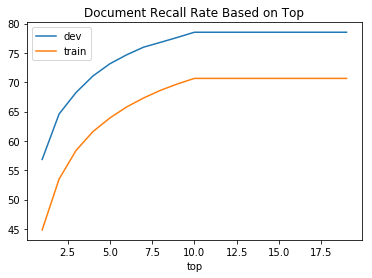

In [187]:
pd.DataFrame.from_records(results).set_index('top').plot.line(title='Document Recall Rate Based on Top')
plt.show()

In [188]:
results_df.head()

,claim_id,found_doc,rank,percentage,weight
0,3,Chris_Hemsworth,1,77,35.874716
1,3,Hemsworth_-LRB-surname-RRB-,2,58,26.919077
2,3,Kim_Hyde,3,47,22.099664
3,3,Liam_Hemsworth,4,46,21.552361
4,3,Vanessa_Zachos,5,46,21.329802


In [190]:
%%time

results = []
for top in range(5, 100, 5):
    print(top)
    mask = results_df['percentage'] >= top
    
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
CPU times: user 2min 32s, sys: 2.6 s, total: 2min 34s
Wall time: 2min 35s


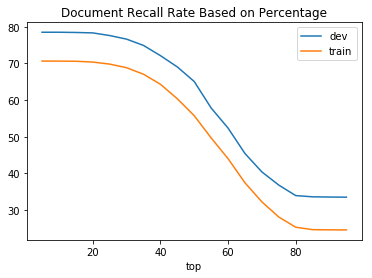

In [191]:
pd.DataFrame.from_records(results).set_index('top').plot.line(title='Document Recall Rate Based on Percentage')
plt.show()

In [192]:
%%time

results = []
for top in range(10, 30, 2):
    print(top)
    mask = results_df['weight'] >= top
    
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

10
12
14
16
18
20
22
24
26
28
CPU times: user 1min 36s, sys: 2.16 s, total: 1min 38s
Wall time: 1min 38s


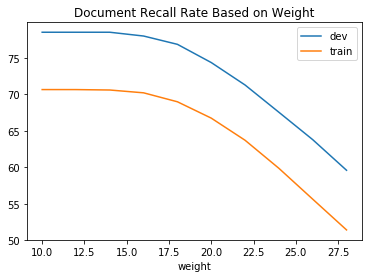

In [195]:
pd.DataFrame.from_records(results).set_index('weight').plot.line(title='Document Recall Rate Based on Weight')
plt.show()

## Prepare submission

In [110]:
submission_df = results_df[results_df['rank'] == 1].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
claim_id,,
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
4,Chris_Hemsworth,Chris Hemsworth disappeared in A Perfect Getaway.
7,Roald_Dahl_Museum_and_Story_Centre,Roald Dahl is a writer.
8,The_Collected_Short_Stories_of_Roald_Dahl,Roald Dahl is a governor.
9,Slieverue,Ireland has relatively low-lying mountains.


In [111]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [112]:
del submission_df['found_doc']

In [113]:
submission_df.to_json('testoutput.json', orient='index')

In [114]:
submission_df.shape

(150450, 3)

## Evidence found

In [122]:
found_df = labelled_claims_df[(labelled_claims_df.missed_count == 0) & (labelled_claims_df.label != 'NOT ENOUGH INFO')]

In [123]:
found_df.evidence_docs.astype(str).value_counts().to_frame()

,evidence_docs
['Snoop_Dogg'],125
['David_Beckham'],88
['Carrie_Fisher'],87
['Planet_of_the_Apes_-LRB-1968_film-RRB-'],85
['Anne_Hathaway'],84
['Tim_Rice'],81
['Jeff_Bezos'],80
['Tom_Felton'],80
['Imagine_Dragons'],79
['Eminem'],75


## Evidence missed

In [124]:
missed_df = labelled_claims_df[labelled_claims_df.missed_count > 0]

In [125]:
missed_df = missed_df.join(claim_df[['named_entities', 'np_phrase']])

In [126]:
cols = ['claim', 'named_entities', 'np_phrase', 'evidence_docs',
       'evidence_doc_count', 'found_doc', 'missed_docs', 'missed_count']
missed_df.sort_values(['missed_count', 'evidence_set_str'], ascending=[False, True])[cols].head(100)

,claim,named_entities,np_phrase,evidence_docs,evidence_doc_count,found_doc,missed_docs,missed_count
1885,Leonardo DiCaprio is an actor.,"[{'entity': 'Leonardo DiCaprio', 'label': 'PERSON', 'root': 'DiCaprio'}]","[Leonardo DiCaprio, an actor]","[Body_of_Lies_-LRB-film-RRB-, Romeo_+_Juliet, Blood_Diamond, The_Aviator_-LRB-2004_film-RRB-, Ap...",24,"{Blackadore_Caye, The_Revenant_-LRB-2015_film-RRB-, The_Audition_-LRB-2015_film-RRB-, Mali_Finn,...","{Leonardo_DiCaprio, Catch_Me_If_You_Can, Gangs_of_New_York, Shutter_Island_-LRB-film-RRB-, Marti...",23
163636,There was a musician in the Grand Ole Pry.,"[{'entity': 'the Grand Ole Pry', 'label': 'ORG', 'root': 'Pry'}]","[a musician, the Grand Ole Pry]","[Josh_Turner, Grand_Ole_Opry, Dixie_Chicks, Dierks_Bentley, Dolly_Parton, Reba_McEntire, Roy_Acu...",21,"{22nd_GMA_Dove_Awards, 25th_GMA_Dove_Awards, Charlie_Walker_-LRB-musician-RRB-, Poobong, 31st_GM...","{Kitty_Wells, Blake_Shelton, Patsy_Cline, Carrie_Underwood, Ernest_Tubb, Dixie_Chicks, Garth_Bro...",21
12735,Christiano Ronaldo doesn't play football.,"[{'entity': 'Christiano Ronaldo', 'label': 'PERSON', 'root': 'Ronaldo'}]","[Christiano Ronaldo, football]","[Copa_del_Rey, FIFA_World_Player_of_the_Year, Forward_-LRB-association_football-RRB-, Ballon_d'O...",20,"{Ronaldo, Ronaldo_Maczinski, Messi–Ronaldo_rivalry, Ronaldo_Conceição, Ronaldo_Mendes, Ronaldo_A...","{Ballon_d'Or, Jimmy_Greaves, UEFA_Euro_2016, European_Golden_Shoe, List_of_men's_association_foo...",20
68230,Helena Bonham Carter is unable to act in movies.,"[{'entity': 'Helena Bonham Carter', 'label': 'PERSON', 'root': 'Carter'}]","[movies, Helena Bonham Carter]","[Dark_Shadows_-LRB-film-RRB-, Big_Fish, Fight_Club, Cinderella_-LRB-2015_Disney_film-RRB-, Lady_...",22,"{Eduardo_Propper_de_Callejón, Burton_&_Taylor, Dancing_Queen_-LRB-1993_film-RRB-, Conversations_...","{Dark_Shadows_-LRB-film-RRB-, Corpse_Bride, Cinderella_-LRB-2015_Disney_film-RRB-, Alice_Through...",20
11847,Marlon Brando is an actor.,"[{'entity': 'Marlon Brando', 'label': 'PERSON', 'root': 'Brando'}]","[Marlon Brando, an actor]","[The_Missouri_Breaks, Vito_Corleone, Colonel_Kurtz, Sayonara, The_Formula_-LRB-1980_film-RRB-, R...",19,"{Brando_-LRB-surname-RRB-, Movita_Castaneda, Listen_to_Me_Marlon, Joseph_Brutsman, Jay_Kanter, T...","{Stanley_Kowalski, On_the_Waterfront, Mutiny_on_the_Bounty_-LRB-1962_film-RRB-, Marlon_Brando, A...",19
104782,Cristiano Ronaldo was unathletic.,"[{'entity': 'Cristiano Ronaldo', 'label': 'PERSON', 'root': 'Ronaldo'}]",[Cristiano Ronaldo],"[Copa_del_Rey, 2006_FIFA_World_Cup, Ballon_d'Or, Cristiano_Ronaldo, Captain_-LRB-association_foo...",18,"{Ronaldo, Cristiano, List_of_international_goals_scored_by_Cristiano_Ronaldo, TAP_Portugal_Fligh...","{Ballon_d'Or, List_of_Portugal_national_football_team_captains, Jimmy_Greaves, List_of_men's_ass...",18
7540,Scarlett Johansson is an actress.,"[{'entity': 'Scarlett Johansson', 'label': 'PERSON', 'root': 'Johansson'}]","[Scarlett Johansson, an actress]","[Lucy_-LRB-2014_film-RRB-, North_-LRB-1994_film-RRB-, A_Love_Song_for_Bobby_Long, The_Prestige_-...",21,"{Scarlett_-LRB-given_name-RRB-, Anywhere_I_Lay_My_Head, Scarlett_Johansson, List_of_awards_and_n...","{The_Jungle_Book_-LRB-2016_film-RRB-, The_Black_Dahlia_-LRB-film-RRB-, Lost_in_Translation_-LRB-...",18
127040,Clint Eastwood performs.,"[{'entity': 'Clint Eastwood', 'label': 'PERSON', 'root': 'Eastwood'}]",[Clint Eastwood],"[The_Outlaw_Josey_Wales, Hang_'Em_High, Heartbreak_Ridge, The_Bridges_of_Madison_County_-LRB-fil...",18,"{Eastwood_After_Hours, Space_Cowboys, Clint_Eastwood_-LRB-musician-RRB-, Bronco_Billy, Clint_Eas...","{Any_Which_Way_You_Can, In_the_Line_of_Fire, Escape_from_Alcatraz_-LRB-film-RRB-, Where_Eagles_D...",18
69153,Austria is a film.,"[{'entity': 'Austria', 'label': 'GPE', 'root': 'Austria'}]","[a film, Austria]","[Austria-Hungary, Hungary, Neutral_country, Austrian_State_Treaty, Vienna, Kingdom_of_Prussia, A...",17,"{Alfons_Fryland, Fever_-LRB-2014_film-RRB

In [41]:
missed_df.missed_docs.astype(str).value_counts().to_frame()

,missed_docs
{'Michael_Jackson'},128
{'United_States'},127
{'United_Kingdom'},124
{'Abraham_Lincoln'},113
{'François_de_Belleforest'},99
{'Beyoncé'},95
{'Ronald_Reagan'},95
{'International_relations'},94
{'Marlon_Brando'},93
{'Theodore_Roosevelt'},92
